# Выбор локации для скважины

**Условие:**

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*
___

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.
___

**Для работы нам предоставили 3 региона, в датасетах:**
 
- geo_data_0.csv
- geo_data_1.csv
- geo_data_2.csv

**Данные, которые в них присутствуют:**

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).
___

**План работы:**

- Загрузка и подготовка данных
- Обучение и проверка модели
- Подготовка к расчёту прибыли
- Расчёт прибыли и рисков
- Вывод по работе

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
TEST_SIZE = .25

In [2]:
zero = pd.read_csv('/datasets/geo_data_0.csv')
first = pd.read_csv('/datasets/geo_data_1.csv')
second = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
#Создадим функцию для просмотра и визуализации датафрейма
def df_info(df):
    display(df.head())
    print()
    print(df.info())
    print()
    print(f"Количество очевидных дубликатов = {df.duplicated().sum()}")
    print()
    id_duplicates = df[df.duplicated(['id'], keep=False)]['id'].unique()
    print(f"Количество неуникальных значений в столбце 'id' = {len(id_duplicates)}")
    print()
    print(f"Количество пропусков = {df.isna().sum()}")
    print()
    display(df.describe())
    corr_matrix = df.corr()
    print("Корреляционная матрица:")
    display(corr_matrix)

    for col_name in df.columns:
        if df[col_name].dtype in ['int64', 'float64']:
            fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

            sns.histplot(df[col_name], ax=ax1)
            ax1.set_title(f"Распределение значений признака {col_name}")
            ax1.set_xlabel(col_name)
            ax1.set_ylabel('Количество')

            sns.boxplot(y=df[col_name], ax=ax2)
            ax2.set_title(f"Боксплот признака {col_name}")
            ax2.set_xlabel(col_name)
            ax2.set_ylabel('Значение')

            plt.tight_layout()
            plt.show()

### Первый регион

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Количество очевидных дубликатов = 0

Количество неуникальных значений в столбце 'id' = 10

Количество пропусков = id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Корреляционная матрица:


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


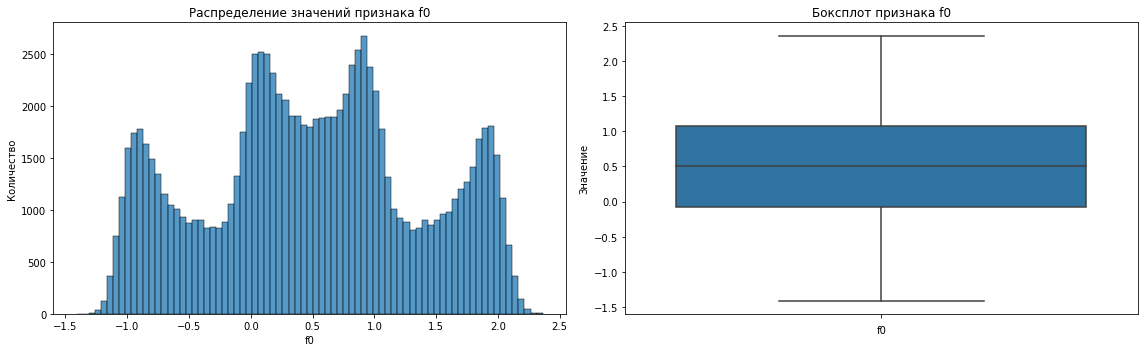

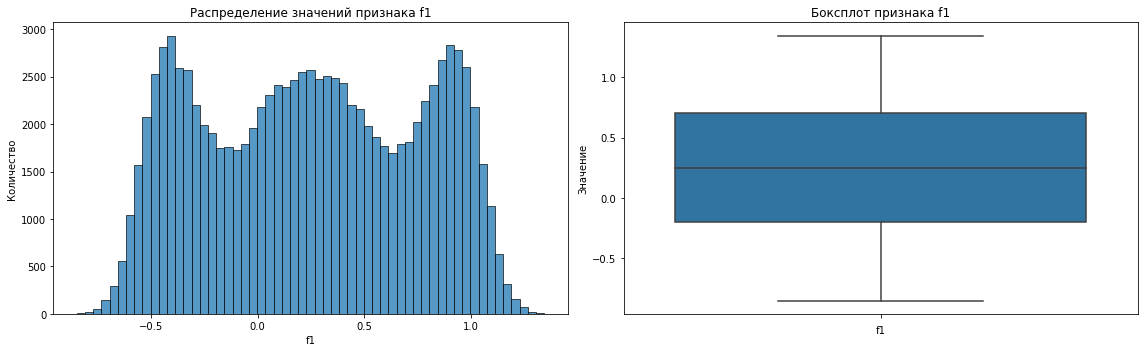

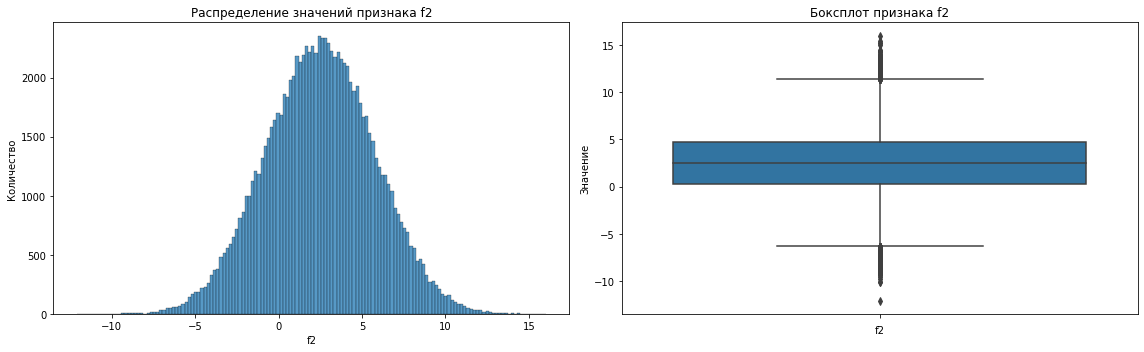

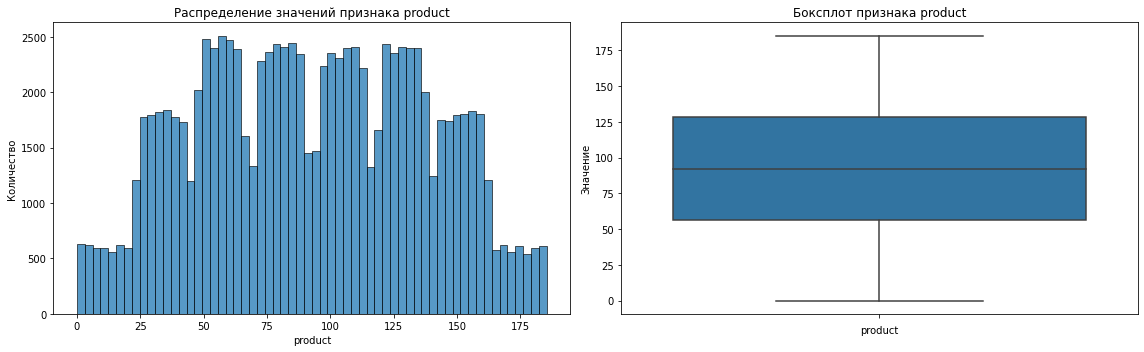

In [4]:
df_info(zero)

In [5]:
#удалим дубликаты по уникальному номеру
zero = zero.drop_duplicates(subset=['id'], keep='first')
zero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


### Второй регион

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Количество очевидных дубликатов = 0

Количество неуникальных значений в столбце 'id' = 4

Количество пропусков = id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Корреляционная матрица:


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


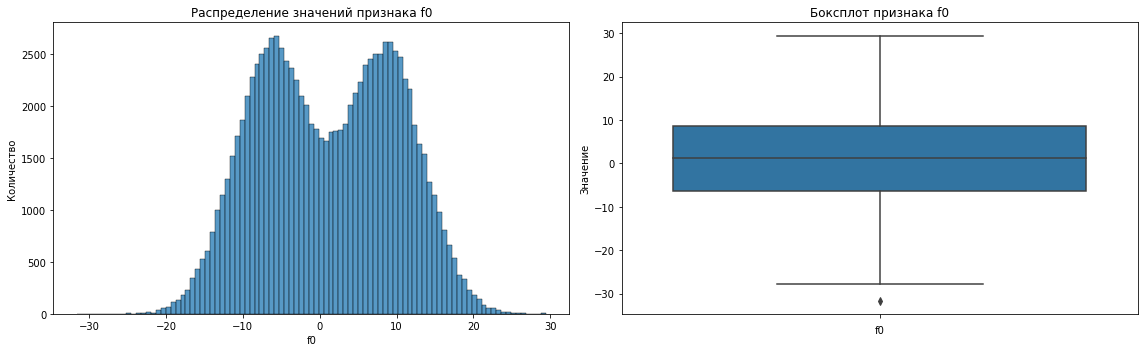

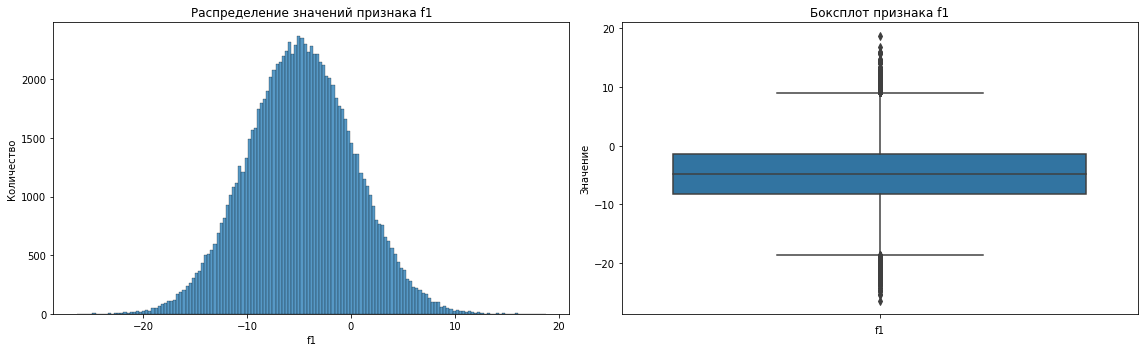

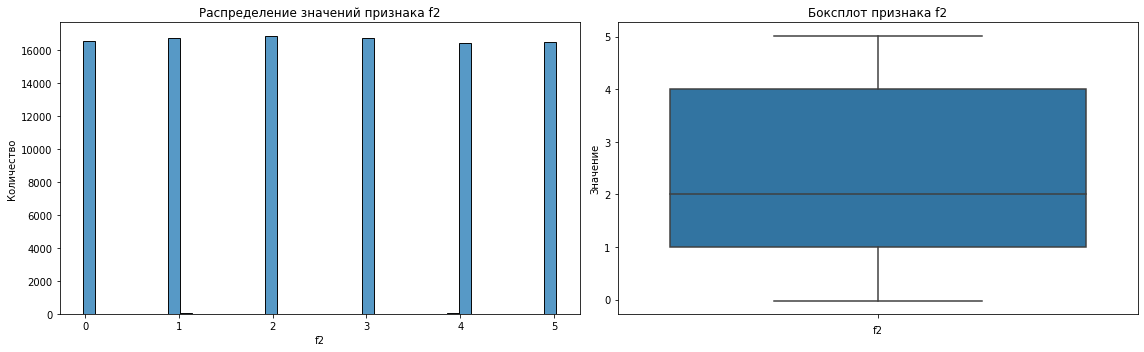

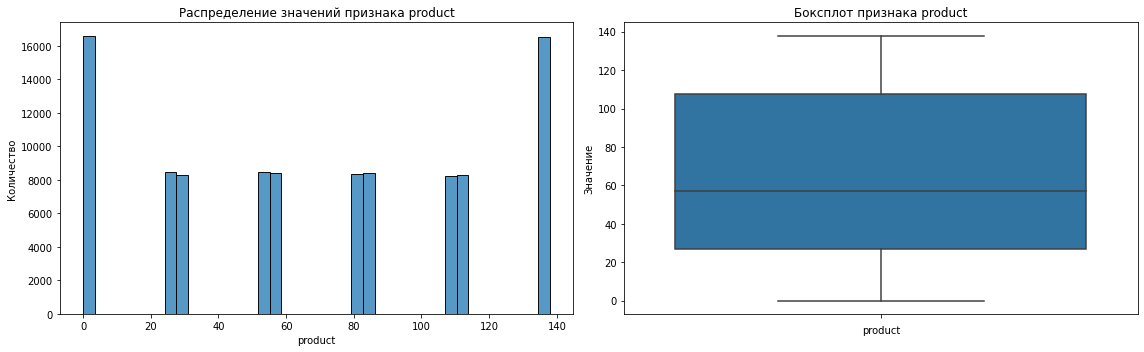

In [6]:
df_info(first)

In [7]:
#удалим дубликаты по уникальному номеру
first = first.drop_duplicates(subset=['id'], keep='first')
first.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


### Третий регион

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Количество очевидных дубликатов = 0

Количество неуникальных значений в столбце 'id' = 4

Количество пропусков = id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Корреляционная матрица:


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


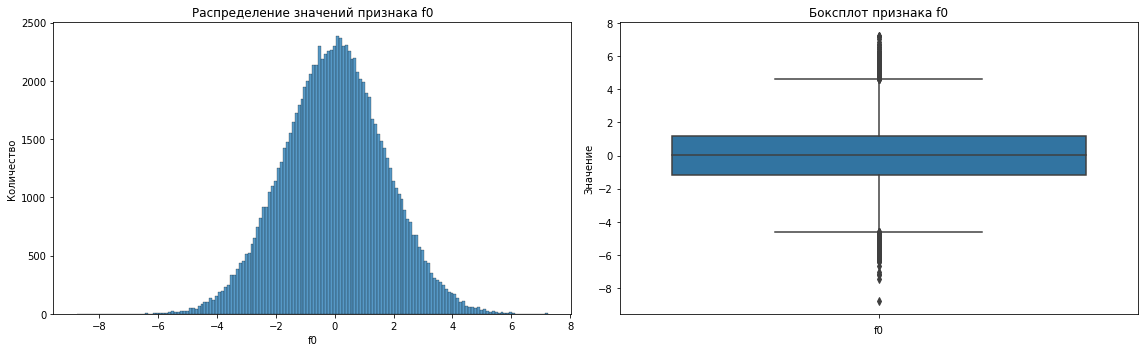

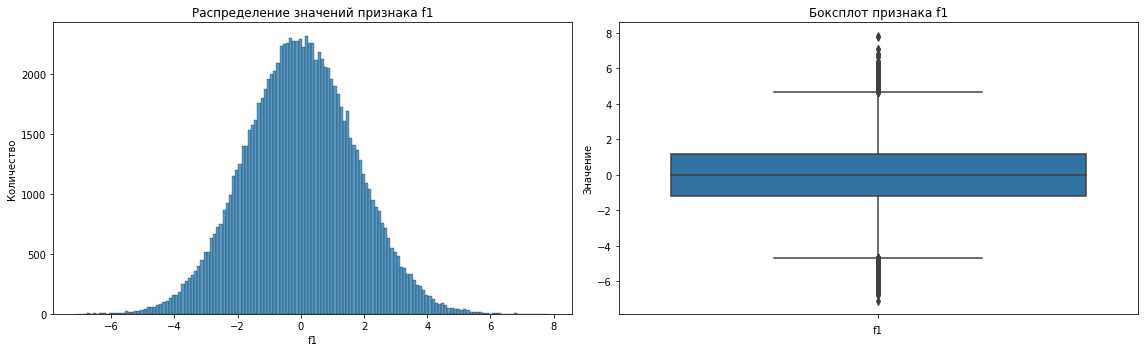

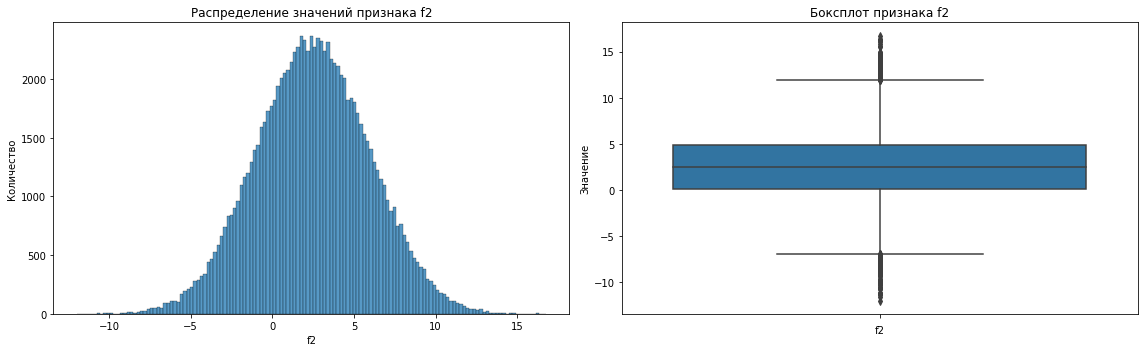

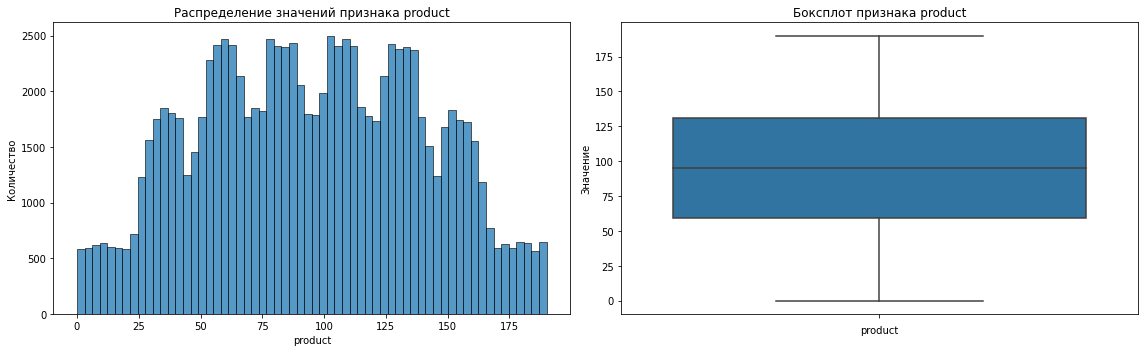

In [8]:
df_info(second)

In [9]:
#удалим дубликаты по уникальному номеру
second = second.drop_duplicates(subset=['id'], keep='first')
second.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


Вывод по обзору и предобработке данных:

- Загружены необходимые библиотеки и проведен анализ данных
- Пропущенные значения отсутствуют
- Явных дублей нет
- Типы данных в корректном формате
- Удалены неявные дубликаты по столбцу с уникальным номером (id):
  - 10 строк из zero
  - 4 строк из first
  - 4 строки из second
- В датасете first наблюдалась сильная корреляция между целевым признаком и f2. Для дальнейшей корректной работы модели, данный столбец удалили
- В датасетах присутствуют выборсы, но аномалий не обнаружено и принято решение не удалять выбросы

## Обучение и проверка модели

In [10]:
#Построим функцию для обучения модели, в которой уже проведем инедексацию и выделим признаки
def ml_reg(data, target_column, region):
    
    data = data.set_index('id')
    X = data.drop(target_column, axis=1)
    y = data[target_column]
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE,
        test_size=TEST_SIZE,
    )
    
    scaler = StandardScaler()
    numeric_columns = ['f0', 'f1', 'f2']
    X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
    X_valid[numeric_columns] = scaler.transform(X_valid[numeric_columns])
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    print('RMSE :', mean_squared_error(y_valid, y_pred, squared=False))
    print(f'Средний запас предсказанно сырья в {region}:', y_pred.mean())
    print('')
    
    df = pd.DataFrame({'real': y_valid, 'predict': y_pred})
    
    return pd.Series(y_pred), pd.Series(y_valid), df

#Обучим и сохраним результаты
predicted_zero, correct_zero, df_zero = ml_reg(zero, 'product', 'zero')
predicted_first, correct_first, df_first = ml_reg(first, 'product', 'first')
predicted_second, correct_second, df_second = ml_reg(second, 'product', 'second')

#Сохраняем индексацию
predicted_zero.index = correct_zero.index
predicted_first.index = correct_first.index
predicted_second.index = correct_second.index

RMSE : 37.68508926201444
Средний запас предсказанно сырья в zero: 92.60984027552017

RMSE : 0.8928265978121422
Средний запас предсказанно сырья в first: 68.57703454115173

RMSE : 40.080822438088305
Средний запас предсказанно сырья в second: 94.93478722287514



Вывод по обучению и проверки модели: 

- Создана функция, т.к. мы работаем с примерно одинаковыми датасетами
- В функции использовали LinearRegression, т.к. она оптимальная и предсказуемая
- В качестве метрики выбрали RMSE

- Согласно метрике RMSE лучше всего модель предсказала на втором регионе **RMSE : 0.8928265978121422**
- Больше всего сырья в третьем регионе **~95 единиц**

## Подготовка к расчёту прибыли

In [11]:
#Задаем данные по условию и считаем объем сырья для безубыточности
#Количество скважен, которое используют для разведки
POINTS = 500 
#Нужное количество скважин 
BEST_POINTS = 200 
#Бюджет на разработку скважин в регионе
BUDGET = 10_000_000_000
#Доход единицы продукта
BARREL_PRICE = 450_000
#Максимум убытков 
LIMIT = .025

REQUIRED_AMOUNT = BUDGET / BEST_POINTS / BARREL_PRICE
print(f'Необходимое кол-во единиц продукта для безубыточности: {REQUIRED_AMOUNT}')

Необходимое кол-во единиц продукта для безубыточности: 111.11111111111111


In [12]:
#Создаем словарь с средними значениями для каждого региона
regions = {
    'zero': predicted_zero.mean(),
    'first': predicted_first.mean(),
    'second': predicted_second.mean()
}

#Проверяем баланс сырья в каждом регионе
for region in regions:
    mean_value = regions[region]
    difference = mean_value - REQUIRED_AMOUNT
    if difference >= 0:
        print(f'В {region} есть излишек сырья в размере {difference:.2f} единиц')
    else:
        print(f'В {region} не хватает {abs(difference):.2f} единиц сырья для безубыточной разработки')

В zero не хватает 18.50 единиц сырья для безубыточной разработки
В first не хватает 42.53 единиц сырья для безубыточной разработки
В second не хватает 16.18 единиц сырья для безубыточной разработки


Вывод по подготовке к расчету прибыли:

- Заданы константы, согласно условиям
- Необходимое кол-во единиц продукта для безубыточности **~111.11**
- Ни один из регионов не достиг необходимого показателя для безубыточности, но лучше всех показал себя 3ий регион

## Расчёт прибыли и рисков 

In [13]:
#Создаем функцию для прибыли
def revenue(target_sample, probabilities_sample, BARREL_PRICE, BUDGET):
    best_200 = probabilities_sample.sort_values(ascending=False).head(200)
    selected = target_sample[best_200.index]
    return selected.sum() * BARREL_PRICE - BUDGET

In [14]:
#Используем бутстрап по заданным данным
def bootstrap(target, probabilities, BARREL_PRICE, BUDGET, region):
    state = np.random.RandomState(RANDOM_STATE)
    values = []
     
    for i in range(1000):
        target_subsample = target.sample(n=POINTS, replace=True, random_state=state)
        
        target_subsample = target_subsample[~target_subsample.index.duplicated()]
    
        probs_subsample = probabilities[target_subsample.index]
        profit = revenue(target_subsample, probs_subsample, BARREL_PRICE, BUDGET)
        values.append(profit)
        
    values = pd.Series(values)
    mean_profit = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    print(f'Регион {region.upper()}:')
    print(f'Средняя прибыль:', mean_profit / 1000)
    print(f'Нижний порог:', lower / 1000)
    print(f'Верхний порог:', upper/ 1000)
    print(f'Риск: {(len(values[values < 0]) / len(values)):.2%}')
    print(' ')

In [15]:
#Применяем и выводим результаты
values_first_region = bootstrap(correct_zero, predicted_zero, BARREL_PRICE, BUDGET, 'zero')
values_second_region = bootstrap(correct_first, predicted_first, BARREL_PRICE, BUDGET, 'first')
values_third_region = bootstrap(correct_second, predicted_second, BARREL_PRICE, BUDGET, 'second')

Регион ZERO:
Средняя прибыль: 389446.29622763285
Нижний порог: -142401.66365612156
Верхний порог: 890059.8378188629
Риск: 6.30%
 
Регион FIRST:
Средняя прибыль: 399809.24143868027
Нижний порог: 19592.297565990262
Верхний порог: 793838.7156594277
Риск: 2.00%
 
Регион SECOND:
Средняя прибыль: 369113.9641705574
Нижний порог: -132526.99344621703
Верхний порог: 895384.8201241276
Риск: 8.50%
 


Вывод по рассчету прибыли и рисков:
    
По заданным показателям риска (<2.5%) подходит 1 регион -  первый:
    - Уровень риска в котором 2%
    - Регион предоставляет 399 миллионов средней прибыли

## Общий вывод

В результате работы была построена модель машинного обучения по определению региона для постройки скважин с наибольшей прибылью.
___

Исследование было разделено на несколько этапов:

1. Загрузка и подготовка данных:

- Изучение общей информации и импорт нужных библиотек
- Загружены 3 датасета
- Создана функция для предоставления общих данных по датасетам
- Удалены неочевидные дубликаты по уникальному номеру (ID)
- Прочие данные в хорошем состоянии и готовы к дальнейшей работе
- Во втором датасете first обнарушена очень сильная корреляция с признаком f2, но, т.к. признак считается важным, принято решение не удалять критерий

2. Обучение и проверка модели

- Создали функцию для обучение модели LinearRegression:
- Разделили выборки к воотношении 75 к 25
- Стандартизировали выборки и применили модель:
 - Согласно метрике RMSE лучше всего модель предсказала на первом регионе **RMSE : 0.8928265978121422**
 - Больше всего сырья в третьем регионе**~95 единиц**


3. Подготовка к расчету прибыли

- Заданы основные показатели согласно переданным условиям
- Необходимое кол-во единиц продукта для безубыточности **~ 111.11**
- Ни один из регион не удовлетворяет требованию к минимальному показателю безубыточности

4. Расчет прибыли и рисков

- Создана функция для подсчета прибыли 
- Применен Bootstrap
___

Стоит дать рекомендацию проверить данные во втором регионе, особенно для показателя f2, в котором была найдена подозрительно высокая корреляция с целевым признаком, что могло повлиять на переобучение
___


Согласно проделанной работе, рекомендовать бурения скважин можно 1ый регион, т.к. он отвечает требованиям заказчика в пороговом проценте убытков:

- В предсказанном регионе наименьший процент убытков (2%)
- Регион приносит в среднем 399 миллионов прибыли
